In [1]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata

In [2]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
# read in CellRanger output data

folders = ["CID005217-1", "CID005221-1", "CID006493-1", "CID006515-1", "CID007664-1", "CID007827-1", "CID008474-1"]
adata_list = []

# read sample
for sample in folders:
    
        #sample = folders[0]
        path = 'C:/Users/saman/00_Bachelorarbeit/Bachelor/data/' + sample + '/filtered/' # TODO: change to universal path here
        adata = sc.read_mtx(
                filename= (path + 'matrix.mtx'),  # the .mtx file 
        )
        adata = adata.transpose()

        # obs = single cells and their barcodes (2312)
        # var = genes and their annotations (33808)

        adata.obs['sampleID'] = sample
        adata.obs['barcode'] = pd.read_csv((path + 'barcodes.tsv'), delimiter='\t', names=['barcode']).values
        adata.var = pd.read_csv((path + 'features.tsv'), delimiter='\t', names=['gene_ids', 'index', 'feature_types'], index_col='index')
        adata.var_names_make_unique()
        adata.obs.index = adata.obs[['sampleID', 'barcode']].agg('-'.join, axis=1)

        adata_list.append(adata)
        print(sample + " done")


CID005217-1 done
CID005221-1 done
CID006493-1 done
CID006515-1 done
CID007664-1 done
CID007827-1 done
CID008474-1 done


In [4]:
adata_list

[AnnData object with n_obs × n_vars = 2312 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 10359 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2452 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1695 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2273 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 949 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 3253 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types']

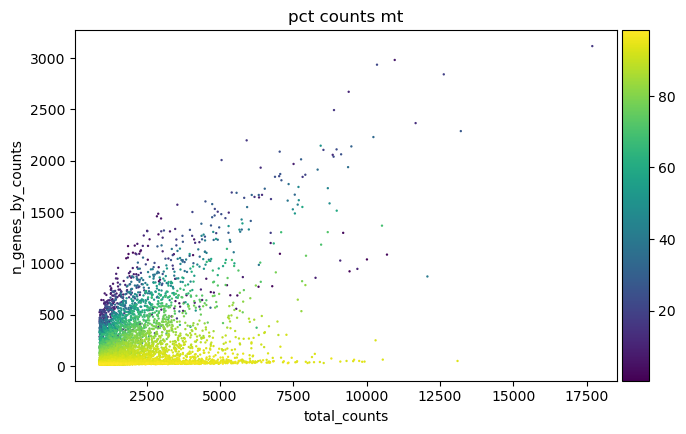

In [73]:
# mitochondrial genes
adata_list[1].var["mt"] = adata_list[1].var_names.str.startswith("MT-")
# ribosomal genes
adata_list[1].var["ribo"] = adata_list[1].var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata_list[1].var["hb"] = adata_list[1].var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(adata_list[1], qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True) #TODO: do we want log1p here?
sc.pl.scatter(adata_list[1], "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## SoupX 

In [7]:
# adata_pp = adata.copy()
# sc.pp.normalize_per_cell(adata_pp)
# sc.pp.log1p(adata_pp)

# sc.pp.pca(adata_pp)
# sc.pp.neighbors(adata_pp)
# sc.tl.leiden(adata_pp, key_added="soupx_groups")

# # Preprocess variables for SoupX
# soupx_groups = adata_pp.obs["soupx_groups"]


# del adata_pp


# cells = adata.obs_names
# genes = adata.var_names
# data = adata.X.T


# raw_path = '../data/qc_data/' + sample + '/Gene/raw'
# adata_raw = sc.read_10x_mtx(
#     path,  # the directory with the `.mtx` file
#     var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
#     cache=True) 

# adata_raw.var_names_make_unique()
# data_tod = adata_raw.X.T

In [8]:
# do SoupX ambient RNA removal here

## Doublet Detection

In [5]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [4]:
%%R
install.packages("scDblFinder")

--- Please select a CRAN mirror for use in this session ---


In [6]:
for sample in range(len(adata_list)):
    data_mat = adata_list[sample].X.T
    %R -i data_mat
    %R set.seed(123)
    %R sce = scDblFinder(SingleCellExperiment(list(counts = data_mat), ))
    %R doublet_score = sce$scDblFinder.score
    doublet_score = ro.globalenv['doublet_score']
    #print(doublet_score)
    adata_list[sample].obs['doublet_score'] = doublet_score

adata_list[0].obs.columns


Error in as(counts(sce), "dgCMatrix") : 
  no method or default for coercing "dgRMatrix" to "dgCMatrix"


RInterpreterError: Failed to parse and evaluate line 'sce = scDblFinder(SingleCellExperiment(list(counts = data_mat), ))'.
R error message: 'Error in as(counts(sce), "dgCMatrix") : \n  no method or default for coercing "dgRMatrix" to "dgCMatrix"'

## Calculation of QC metrics per sample

In [7]:
# outlier threshold definition
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    lower = np.median(M) - nmads * (M - M.mean()).abs().mean()
    upper = np.median(M) + nmads * (M - M.mean()).abs().mean()
    outlier = (M < lower) | (upper < M)
    return outlier, lower, upper


def all_qc_metrics(adata, remove_genes=True):

    metrics = {}
    # mitochondrial genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes.
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

    # calculate QC metrics now

    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True) 

# TODO: remove high value outliers? 0.995 upper percentile
    
    # filter outliers 
    tc_outliers, metrics['tc_lower'], metrics['tc_upper'] = is_outlier(adata, "log1p_total_counts", 4)
    ng_outliers, metrics['ng_lower'], metrics['ng_upper'] = is_outlier(adata, "log1p_n_genes_by_counts", 4)
    top20_outliers, metrics['top20_lower'], metrics['top20_upper'] = is_outlier(adata, "pct_counts_in_top_20_genes", 4)
    adata.obs["outlier"] = (tc_outliers | ng_outliers | top20_outliers)
    
    temp_cell = 0
    if (len(adata.obs.outlier.value_counts()) > 1):
        temp_cell = adata.obs.outlier.value_counts()[1]
    metrics['n_cell_outlier'] = temp_cell

    # filter out high mitochondrial percent cells
    mt_outlier, metrics['mt_lower'], metrics['mt_upper'] = is_outlier(adata, "pct_counts_mt", 3) 
    adata.obs["mt_outlier"] = mt_outlier | ( adata.obs["pct_counts_mt"] > 15) # adjusable value, 15 is permissable, 8 is in best practices book

    temp_mt = 0
    if (len(adata.obs.mt_outlier.value_counts()) > 1):
        temp_mt = adata.obs.mt_outlier.value_counts()[1]
    metrics['n_mt_outliers'] = temp_mt

    # summary of removed cells
    metrics['n_cells_before'] = adata.n_obs
    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    metrics['n_cells_after'] = adata.n_obs

    metrics['n_genes_before'] = adata.n_vars
    if remove_genes:
        # filter out low count genes
        
        # Min 20 cells - filters out 0 count genes
        sc.pp.filter_genes(adata, min_cells=20)
        gene_subset, number_per_gene = sc.pp.filter_genes(adata, min_cells=20, inplace=False)
        #adata.var['gene_subset'] = gene_subset
        #adata.var['number_per_gene'] = number_per_gene
    metrics['n_genes_after'] = adata.n_vars

    return adata, metrics

In [11]:
list_metrics = []
adatas_qced = []

for sample in adata_list:
    adata, metric = all_qc_metrics(sample, remove_genes=False)
    list_metrics.append(list(pd.Series(metric.values())))
    adatas_qced.append(adata)

In [12]:
df_metrics = pd.DataFrame(data = list_metrics, columns = ["tc_lower", "tc_upper", "ng_lower", "ng_upper", "top20_lower", "top20_upper", "n_cell_outlier", "mt_lower", "mt_upper", "n_mt_outliers",
    "n_cells_before", "n_cells_after", "n_genes_before", "n_genes_after"], index=folders)

df_metrics

,tc_lower,tc_upper,ng_lower,ng_upper,top20_lower,top20_upper,n_cell_outlier,mt_lower,mt_upper,n_mt_outliers,n_cells_before,n_cells_after,n_genes_before,n_genes_after
CID005217-1,7.146129,11.398810,5.702253,10.096054,-22.907583,113.181726,78.0,-14.458876,91.659132,324.0,2312.0,324.0,33808.0,33808.0
CID005221-1,5.758498,8.812515,-0.313205,7.365926,58.378810,140.019360,659.0,54.580342,131.275172,0.0,10359.0,0.0,33808.0,33808.0
CID006493-1,6.896954,10.090691,4.239648,10.321747,-69.290283,127.867788,132.0,-69.821949,96.777821,1155.0,2452.0,1279.0,33808.0,33808.0
CID006515-1,6.629152,11.125054,6.051552,9.279018,-28.437982,76.459346,60.0,-30.417998,52.925185,708.0,1695.0,969.0,33808.0,33808.0
CID007664-1,7.060656,11.058147,5.232054,9.754581,-25.299601,129.940569,87.0,-47.412933,82.189301,1037.0,2273.0,1036.0,33808.0,33808.0
CID007827-1,7.474007,11.606719,5.658671,9.868222,-41.736334,125.038839,19.0,-37.027208,63.453943,440.0,949.0,509.0,33808.0,33808.0
CID008474-1,7.792420,11.365724,6.212671,9.859181,-37.042009,103.861065,10.0,-21.757519,56.526844,1281.0,3253.0,1280.0,33808.0,33808.0


In [13]:
adatas_qced.pop(1) # remove weird 5221 sample (for now)
adatas_qced

[AnnData object with n_obs × n_vars = 324 × 33808
     obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
     var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
 AnnData object with n_obs × n_vars = 1279 × 33808
     obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outli

In [14]:
# concat all sample anndata objects into one
adata = anndata.concat(adatas_qced)
adata

AnnData object with n_obs × n_vars = 5397 × 33808
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'

In [ ]:
# inner vs outer join: 
# outer join -> 15844 genes (num of genes with at least 20 cells in one sample)
# inner join -> 10962 genes (num of genes with at least 20 cells in every sample)

# number of genes with at least 20 cells in any sample: 17893 (USE THIS)

In [15]:
# remove low counts genes over all samples
sc.pp.filter_genes(adata, min_cells=20)
adata

AnnData object with n_obs × n_vars = 5397 × 16719
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'n_cells'

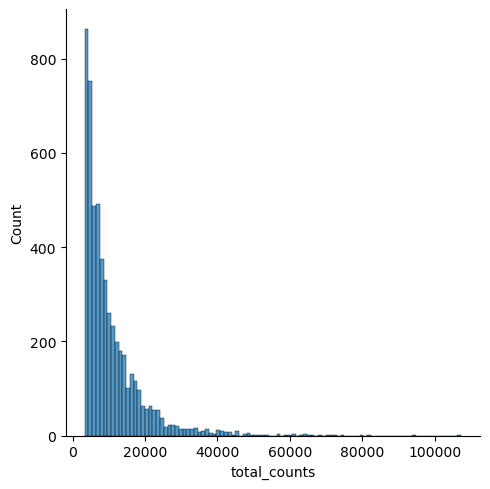

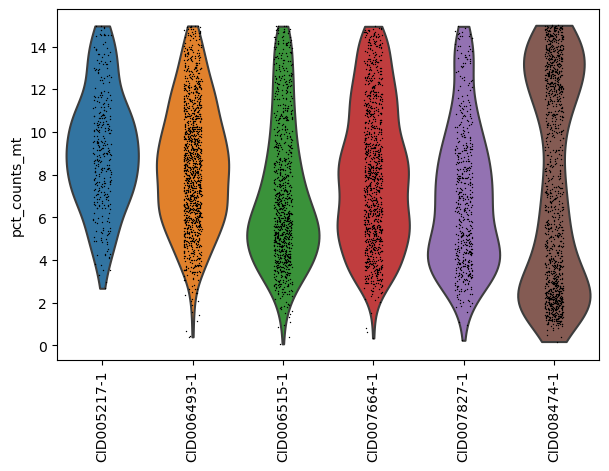

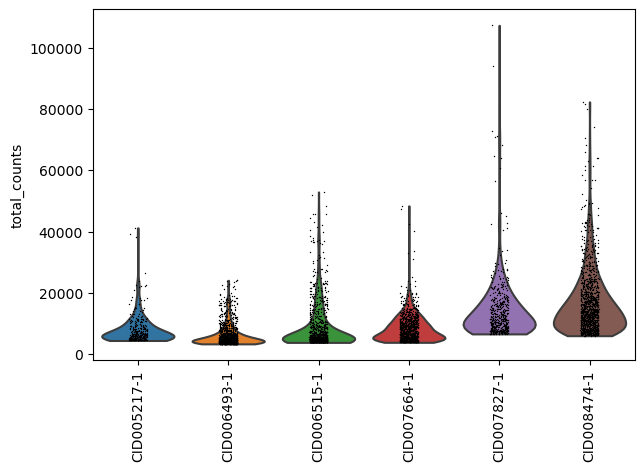

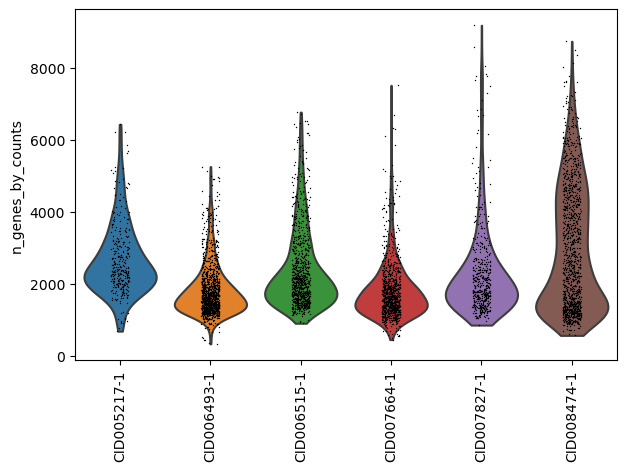

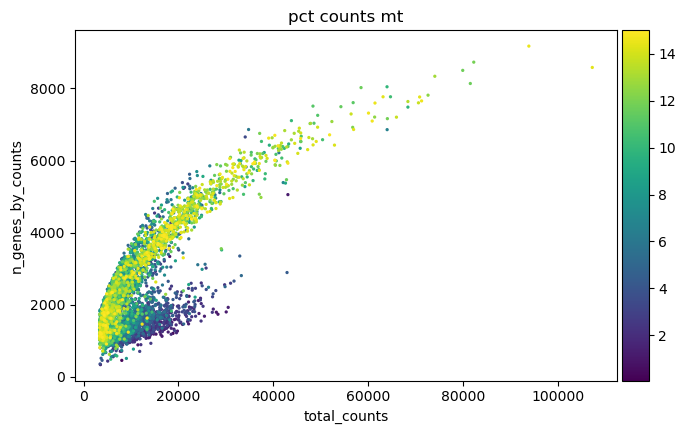

In [16]:
# plotting QC metrics AFTER QC CORRECTION ON EACH SAMPLE INDIVIDUALLY

p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt", groupby= "sampleID", rotation=90)
p3 = sc.pl.violin(adata, "total_counts", groupby= "sampleID", rotation=90)
p4 = sc.pl.violin(adata, "n_genes_by_counts", groupby= "sampleID", rotation=90)
p5 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt") # TODO plot 95th percentile line 
#p6 = sns.displot(adata.obs["doublet_score"], bins=100, kde=False)

In [17]:
# write raw data to file for scvi integration

adata.write_h5ad(
    "C:/Users/saman/00_Bachelorarbeit/Bachelor/data/output/adata_raw.h5ad"
)

## TC Normalization

In [18]:
# function to plot histogram for given adata layer

def plot_hist(adata, ax, layer_name, bin_num=1000): # higher bin numbers made zeros in tc_norm_log disappear? 
    df = adata.to_df(layer=layer_name)
    ninenine = np.percentile(df.values, 99.75)
    nineseven = np.percentile(df.values, 97.5)
    df[df > ninenine] = ninenine # remove high count outliers, can't do NaN so just make equal to new max value?? 
    
    hist, edges = np.histogram(df, bins=bin_num)

    ax.bar(edges[:-1], hist, width = max(edges)/bin_num, color='#0504aa', align='edge')
    ax.set_title(layer_name)
    ax.set_xlim(min(edges), np.percentile(df.values, 98))
    ax.set_ylim(0, np.percentile(hist, 99.75))
    ax.grid(axis='y', alpha=0.75)
    ax.set_xlabel('Gene Expression')
    ax.set_ylabel('Frequency')
    ax.vlines(nineseven, ymin=0, ymax=max(hist), linestyle="--", color="r", label='97.5%')
    ax.legend()
    
    return ax

In [19]:
adata = anndata.read_h5ad(
    "C:/Users/saman/00_Bachelorarbeit/Bachelor/data/output/adata_integrated.h5ad"
)
adata

AnnData object with n_obs × n_vars = 5397 × 16719
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'sampleID_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'int_norm'
    obsp: 'connectivities', 'distances'

In [34]:
# make normalized and log transformed layers

adata_norm = adata.copy()

adata_norm.layers['raw'] = adata_norm.X

adata_norm.layers['log_int_norm'] = sc.pp.log1p(adata_norm.layers['int_norm'], copy=True)

adata_norm.layers['norm'] = sc.pp.normalize_total(adata_norm, inplace=False)['X']

adata_norm.layers['log_norm'] = sc.pp.log1p(adata_norm.layers['norm'], copy=True)

adata_norm

AnnData object with n_obs × n_vars = 5397 × 16719
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'sampleID_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'int_norm', 'raw', 'log_int_norm', 'norm', 'log_norm'
    obsp: 'connectivities', 'distances'

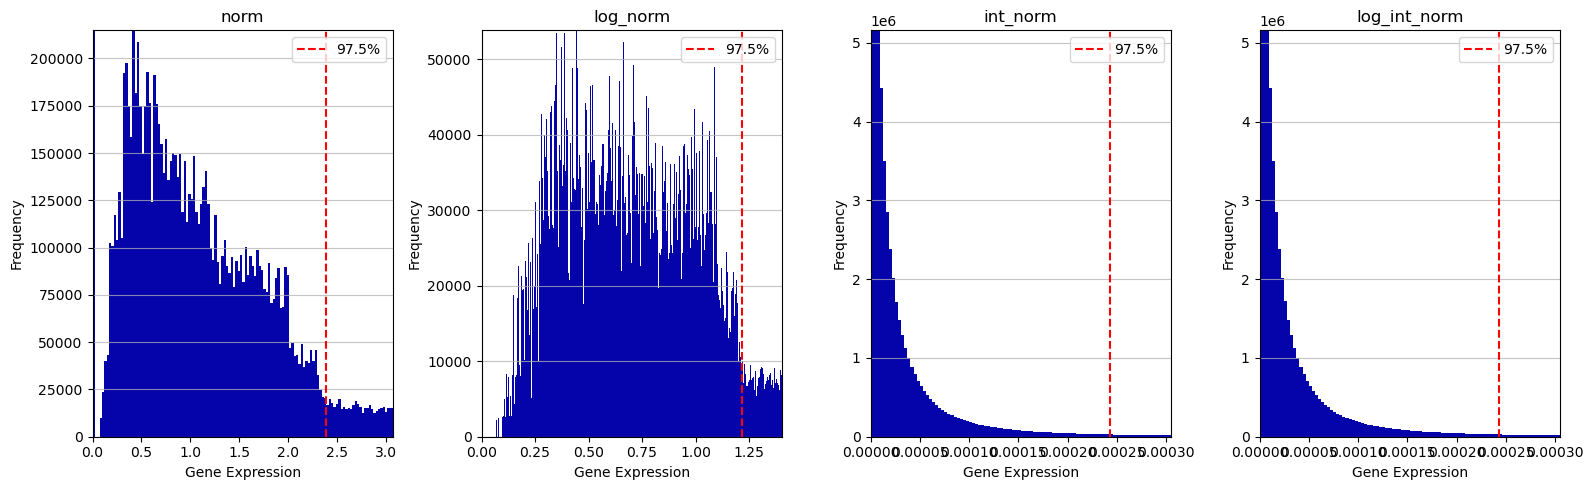

In [36]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,5))
#ax0 = plot_hist(adata_norm.to_df(layer='raw'), ax=ax0, layer_name='raw') 
ax1 = plot_hist(adata_norm, ax=ax1, layer_name='norm')
ax2 = plot_hist(adata_norm, ax=ax2, layer_name='log_norm')
ax3 = plot_hist(adata_norm, ax=ax3, layer_name='int_norm')
ax4 = plot_hist(adata_norm, ax=ax4, layer_name='log_int_norm')
fig.tight_layout()
plt.show()

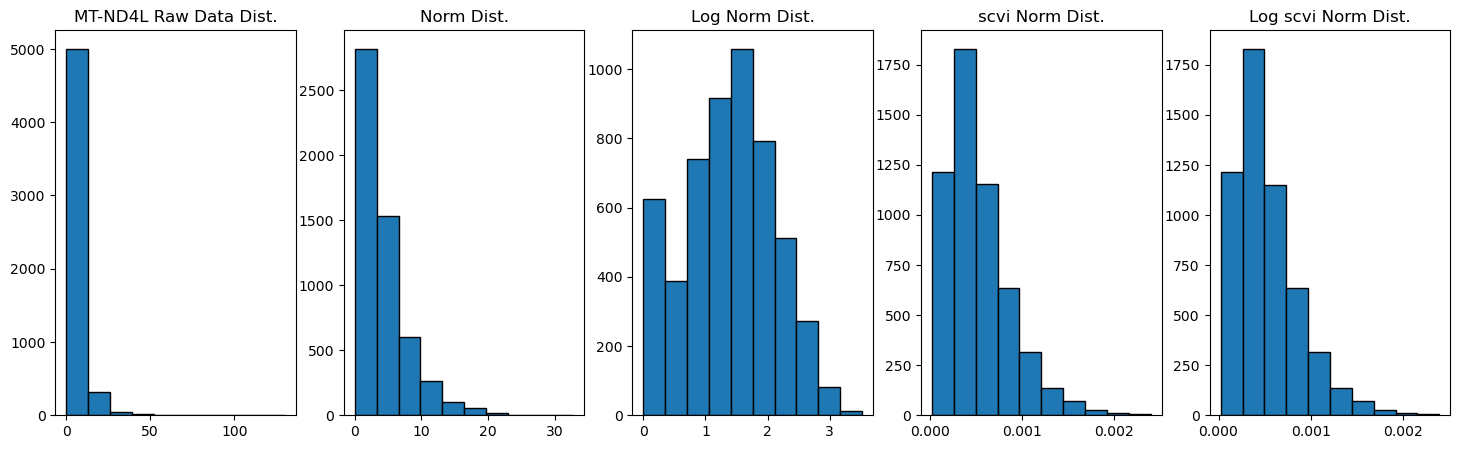

In [35]:
# show histograms of only one gene data

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(18,5))
ax1.hist(adata_norm.to_df(layer='raw')["MT-ND4L"], edgecolor="black")
ax1.set_title('MT-ND4L Raw Data Dist.')
ax2.hist(adata_norm.to_df(layer='norm')["MT-ND4L"], edgecolor="black")
ax2.set_title('Norm Dist.')
ax3.hist(adata_norm.to_df(layer='log_norm')["MT-ND4L"], edgecolor="black")
ax3.set_title('Log Norm Dist.')
ax4.hist(adata_norm.to_df(layer='int_norm')["MT-ND4L"], edgecolor="black")
ax4.set_title('scvi Norm Dist.')
ax5.hist(adata_norm.to_df(layer='log_int_norm')["MT-ND4L"], edgecolor="black")
ax5.set_title('Log scvi Norm Dist.')
plt.show()

In [37]:
adata_norm.write_h5ad(
    "C:/Users/saman/00_Bachelorarbeit/Bachelor/data/output/adata_norms.h5ad"
)

## HVGS and Dimensionality Reduction

In [56]:
# function to select batch key and perform HVG selection, PCA, and UMAP on this subset

def batch_reduction(adata, batch_key=None):
    temp = adata.copy()
    # HVG selection using inputted batch key
    sc.pp.highly_variable_genes(temp, n_top_genes=2000, batch_key=batch_key, subset=True)

    # dimensionality reduction
    sc.pp.pca(temp, n_comps=50, svd_solver="arpack") #PCA
    sc.pp.neighbors(temp)
    sc.tl.umap(temp) # UMAP

    return temp

In [58]:
adata_norm.X = adata_norm.layers['tc_norm_log']
adata_new = batch_reduction(adata)
adata_new

AnnData object with n_obs × n_vars = 7641 × 2000
    obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'sampleID_colors', 'umap', 'log1p', 'hvg', 'pca'
    obsm: 'X_scVI', 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'integrated'
    obsp: 'connectivities', 'distances'

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


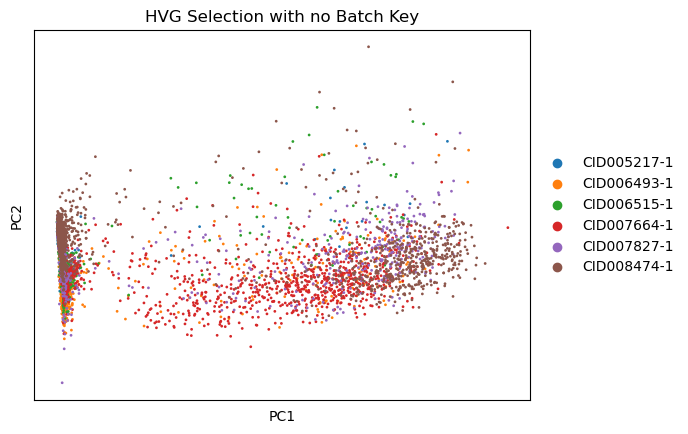

In [59]:
color = "sampleID"

pca1 = sc.pl.pca_scatter(adata_new, color=color, title="HVG Selection with no Batch Key")

## UMAPs

In [60]:
# UMAPs
sc.tl.umap(adata_new)

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


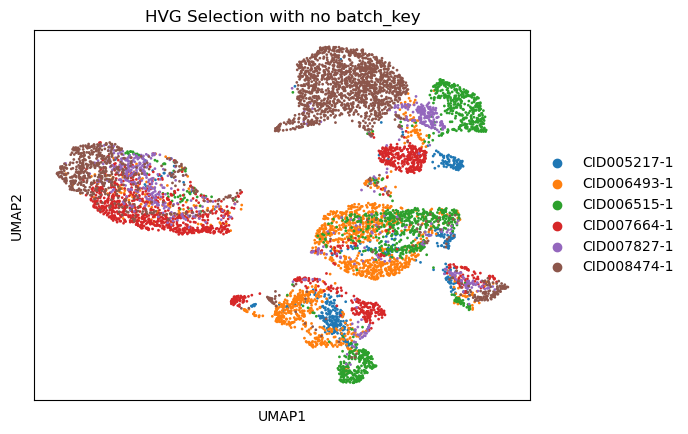

In [61]:
# color by corresponding batch var 

umap1 = sc.pl.umap(adata_new, color=color, title='HVG Selection with no batch_key') 